In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pylab
import seaborn as sns
import os
from os import path
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from scipy.cluster.hierarchy import fcluster, fclusterdata, linkage, dendrogram 
import matplotlib.patches as patches
from copy import deepcopy
import pickle
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# common formatting
plt.style.use('synthetic-enhancer-footprinting.mplstyle')
# plt.style.use('seaborn-white')

import sys  
sys.path.insert(0, '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/code/amplicon-smf/workflow/scripts')

import common

import importlib
importlib.reload(common)
%matplotlib inline

color_dict = {'TetO': '#457FF9', 'minCMV': "0.5", 'TATABox': "0.25"}

import matplotlib.font_manager


In [2]:
def get_methyl_positions(mat):
    '''
    Extracts meaningful columns from a single molecule methylation matrix
    Uninformative positions are stored as -1, so take only the columns with non-negative means 
    This isn't exactly correct but will do the trick for now, I think.
    '''

    return mat.loc[:,mat.mean()>=0].columns.tolist()

def load_single_molecule_matrix(path, every_other=True):
    '''
    Reads a single-molecule matrix from file, extracts the meaningful columns (using the function above) and returns
    Optionally (default) drops the duplicated columns (idk why but Georgi's script has 2 columns per GpC, one per C I guess?)
    '''
    mat = pd.read_table(path, index_col=0)
    mat.columns = [int(c) for c in mat.columns] # convert cols to ints (helpful later)
    methyl_positions = get_methyl_positions(mat)
    if every_other:
        # filter out the duplicates (so each GpC only has one column)
        methyl_positions = [p for idx,p in enumerate(methyl_positions) if idx % 2 == 0]
    return mat[methyl_positions].copy()

def load_single_molecule_matrix2(path, every_other=True):
    '''
    Reads a single-molecule matrix from file, extracts the meaningful columns (using the function above) and returns
    Optionally (default) drops the duplicated columns (idk why but Georgi's script has 2 columns per GpC, one per C I guess?)
    '''
    mat = pd.read_table(path, index_col=0)
    mat.columns = [int(c) for c in mat.columns] # convert cols to ints (helpful later)
    return mat.copy()


def load_tfbs_positions(f):
    '''
    Loads a file of positions to color on the bulk SMF plots
    File looks like:
    >amplicon
    101,105,name
    299,420,name
    ...
    >amplicon2
    ...
    Returns dict of amplicon->list of (start,end) tuples
    '''
    pos_dict = {}
    amplicon = ''

    with open(f) as pos_file:
        for line in pos_file:
            if line.startswith('>'):
                amplicon = line.strip().lstrip('>')
                # can't have repeated headings, fine
                pos_dict[amplicon] = []
            else:
                line_split = line.strip().split(',')
                line_split[0] = int(line_split[0])
                line_split[1] = int(line_split[1])
                tup = (int(line_split[0]), int(line_split[1]), line_split[2])
                pos_dict[amplicon].append(line_split)

    return pos_dict

def add_fillbetween(ax, locs, label_on=True):
    '''
    Adds highlighting to the region(s) defined in locs
    Locs should be a list of (start,end) tuples defining regions of interest
    Maybe can add label support in the future?
    '''
    ymin, ymax = ax.get_ylim()

    # for (start, end, label, *color) in locs:
    for loc in locs:
        start, end, label, *color = loc
        c = color[0] if color else 'r'
        l = label if label_on else None
        ax.fill_between((start,end), (ymin,ymin), (ymax,ymax), color=c, alpha=0.2, label=l)
        
def plot_single_reads(mat, ax, axis_label=None, interpolation='antialiased'):
    '''
    Plot single reads (clustered however) from mat on ax
    Mat should have 0 = methylated = accessible and 1 = unmethylated = protected
    -1 for positions where there is no data
    Then we map the colors and use gray cmap so 1->0=black and 0->0.7=gray (and -1->1=white)
    So black corresponds to protection and gray to open (and white to nada)
    '''
    new_mat = pd.DataFrame(-1, index=mat.index, columns=mat.columns)
    for c in mat.columns:
        new_mat[c] = mat[c].map({1:0,0:0.7,-1:1})    
    ax.imshow(new_mat, aspect='auto', cmap=plt.get_cmap('gray'), interpolation=interpolation)
    if axis_label:
        ax.set_ylabel(axis_label)

def fix_missing_data(mat):
    '''
    Substitute -1 (= missing) in single molecule matrix with 0.5 for clustering stuff
    '''
    return mat.replace(-1,0.5)

def cluster_matrix_and_plot(mat_path, ax, n_clusters=6, n=None):
    mat = pd.read_table(mat_path, index_col=0)
    mat.columns = [int(x) for x in mat.columns]

    methyl_positions = mat.loc[:,mat.mean()>0].columns.tolist()
        
    df = mat.copy().sample(n=n)
    kmeans = KMeans(n_clusters=n_clusters).fit(df)
    df['cluster'] = kmeans.labels_

    plot_single_reads(df.sort_values('cluster').drop('cluster', axis=1), ax)
    
def cluster_matrix_and_plot3(mat, ax, interpolation='antialiased'):
    '''
    Cluster single reads in mat and return newly ordered matrix
    Note, this is super clunky since we are calling clustermap! No reason
    We shoudl actually just figure out whatever linkage it uses and return that (can do later)
    Also can optionally add in cols to use for clustering? 
    I don't think that any distance function will be tricked by entirely identical columns though...
    '''
    cm = sns.clustermap(mat, col_cluster=False)
    plt.clf()
    rows = cm.dendrogram_row.reordered_ind
    df = mat.reset_index().loc[rows].copy()
    plot_single_reads(df, ax, interpolation=interpolation)
    
    
def cluster_matrix_and_plot2(mat, ax, n_clusters=6, n=None):
#     methyl_positions = mat.loc[:,mat.mean()>0].columns.tolist()
        
    df = mat.copy().sample(n=n)
    kmeans = KMeans(n_clusters=n_clusters).fit(df)
    df['cluster'] = kmeans.labels_

    plot_single_reads(df.sort_values('cluster').drop('cluster', axis=1), ax)

pos_file4 = '/oak/stanford/groups/wjg/bgrd/projects/smf/220829_P026_opJS45/amplicon-info/opJS4.positions.long.txt'
pos_file5 = '/oak/stanford/groups/wjg/bgrd/projects/smf/220829_P026_opJS45/amplicon-info/opJS5.positions.long.txt'
positions_dict4 = load_tfbs_positions(pos_file4)
positions_dict5 = load_tfbs_positions(pos_file5)
positions_dict = positions_dict4

In [6]:
basedir = '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/model_running'
basedir2 = '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/model_running'
basedir3 = '/oak/stanford/groups/wjg/mhinks/projects/smf/220925_P030_doxtimecourse_opJS45/model_running'
samples = ['gSMF166-opJS45ctcf-24hr-1000ngdox-b1',
           'gSMF167-opJS45ctcf-24hrdox-24hrA485-b1',
           'gSMF168-opJS45ctcf-24hrdox-8hrA485-b1',
           'gSMF169-opJS45ctcf-24hrdox-24hrBRM014-b1',
           'gSMF170-opJS45ctcf-24hrdox-8hrBRM014-b1',
           'gSMF171-opJS45ctcf-24hrdox-90minflavo-b1',
           'gSMF172-opJS45ctcf-24hrdox-30minflavo-b1',
           'L281_gSMF92_opJS45_b1_24hrdox', 
           'L282_gSMF93_opJS45_b1_8hrdox',
           'gSMF174-opJS45ctcf-24hr-1000ngdox-b2', 
           'gSMF175-opJS45ctcf-24hrdox-24hrA485-b2', 
           'gSMF176-opJS45ctcf-8hrdox-8hrA485-b2', 
           'gSMF177-opJS45ctcf-24hrdox-24hrBRM014-b2', 
           'gSMF178-opJS45ctcf-8hrdox-8hrBRM014-b2', 
           'gSMF179-opJS45ctcf-24hrdox-90minflavo-b2', 
           'gSMF180-opJS45ctcf-24hrdox-30minflavo-b2', 
           'L289_gSMF100_opJS45_b2_24hrdox', 
           'L290_gSMF101_opJS45_b2_8hrdox']    

amplicons4 = ['opJS4_8x_TetO_21bp_no_CG', 'opJS4_7x_TetO_21bp_no_CG', 'opJS4_6x_TetO_21bp_no_CG', 'opJS4_5x_TetO_21bp_no_CG', 'opJS4_4x_TetO_21bp_no_CG', 'opJS4_3x_TetO_21bp_no_CG', 'opJS4_2x_TetO_21bp_no_CG', 'opJS4_1x_TetO_21bp_no_CG', 'opJS4_0x_TetO_21bp_no_CG', 'opJS5_CTCF', 'opJS5_BD24']
amplicons5 = ['opJS5_0xTetO_18bp_b1', 'opJS5_0xTetO_18bp_b2', 'opJS5_1xTetO_18bp_b1', 'opJS5_1xTetO_18bp_b2', 'opJS5_2xTetO_18bp_b1', 'opJS5_2xTetO_18bp_b2', 'opJS5_3xTetO_18bp_b1', 'opJS5_3xTetO_18bp_b2', 'opJS5_4xTetO_18bp_b1', 'opJS5_4xTetO_18bp_b2', 'opJS5_5xTetO_18bp_b1', 'opJS5_5xTetO_18bp_b2', 'opJS5_6xTetO_18bp_b1', 'opJS5_6xTetO_18bp_b2', 'opJS5_7xTetO_18bp_b1', 'opJS5_7xTetO_18bp_b2', 'opJS5_8xTetO_18bp_b1', 'opJS5_8xTetO_18bp_b2', 'opJS5_9xTetO_18bp_b1', 'opJS5_9xTetO_18bp_b2', 'opJS5_CTCF', 'opJS5_BD24']
amplicons = amplicons4 + amplicons5

samp_to_amp_to_classification_dict = {}

for samp in samples:
    tmp_dict = {}
    for amplicon in amplicons:
        for basedir_ in [basedir, basedir2, basedir3]:
            p = path.join(basedir_,samp,'{}.{}.single_molecule_classification.txt'.format(samp, amplicon))
            if path.exists(p):
                df = pd.read_table(p, index_col=0)
                df.index = ['{}-{}-{}'.format(samp,amplicon,i) for i in df.index]
                tmp_dict[amplicon] = df.copy()
    samp_to_amp_to_classification_dict[samp] = deepcopy(tmp_dict)

samp_to_amp_to_classification_dict[samples[0]][amplicons[0]].head()

single_molecule_dirs = {'gSMF166-opJS45ctcf-24hr-1000ngdox-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'gSMF167-opJS45ctcf-24hrdox-24hrA485-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'gSMF168-opJS45ctcf-24hrdox-8hrA485-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'gSMF169-opJS45ctcf-24hrdox-24hrBRM014-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'gSMF170-opJS45ctcf-24hrdox-8hrBRM014-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'gSMF171-opJS45ctcf-24hrdox-90minflavo-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'gSMF172-opJS45ctcf-24hrdox-30minflavo-b1': '/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse',
           'L281_gSMF92_opJS45_b1_24hrdox': '/oak/stanford/groups/wjg/mhinks/projects/smf/220925_P030_doxtimecourse_opJS45/results_timecourse/doxtimecourse', 
           'L282_gSMF93_opJS45_b1_8hrdox': '/oak/stanford/groups/wjg/mhinks/projects/smf/220925_P030_doxtimecourse_opJS45/results_timecourse/doxtimecourse',
           'gSMF174-opJS45ctcf-24hr-1000ngdox-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'gSMF175-opJS45ctcf-24hrdox-24hrA485-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'gSMF176-opJS45ctcf-8hrdox-8hrA485-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'gSMF177-opJS45ctcf-24hrdox-24hrBRM014-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'gSMF178-opJS45ctcf-8hrdox-8hrBRM014-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'gSMF179-opJS45ctcf-24hrdox-90minflavo-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'gSMF180-opJS45ctcf-24hrdox-30minflavo-b2': '/oak/stanford/groups/wjg/bgrd/projects/smf/230108_P046_drugtimecourse_2/results/drug_timecourse', 
           'L289_gSMF100_opJS45_b2_24hrdox': '/oak/stanford/groups/wjg/mhinks/projects/smf/220925_P030_doxtimecourse_opJS45/results_timecourse/doxtimecourse', 
           'L290_gSMF101_opJS45_b2_8hrdox': '/oak/stanford/groups/wjg/mhinks/projects/smf/220925_P030_doxtimecourse_opJS45/results_timecourse/doxtimecourse'}

samp_to_amp_to_single_molecule_dict = {}
samp_to_amp_to_full_single_molecule_dict = {}

for samp in samples:
    tmp_dict1 = {}
    tmp_dict2 = {}
    for amplicon in amplicons:
        p = path.join(single_molecule_dirs[samp], samp, 'matrices', '{}.{}.full_unclustered.matrix'.format(samp,amplicon))
        if path.exists(p):
            df1 = load_single_molecule_matrix(p)
            df2 = load_single_molecule_matrix2(p)
            df1.index = ['{}-{}-{}'.format(samp,amplicon,i) for i in df1.index]
            df2.index = ['{}-{}-{}'.format(samp,amplicon,i) for i in df2.index]
            tmp_dict1[amplicon] = df1.copy()
            tmp_dict2[amplicon] = df2.copy()
        else:
            print(p)
    samp_to_amp_to_single_molecule_dict[samp] = deepcopy(tmp_dict1)
    samp_to_amp_to_full_single_molecule_dict[samp] = deepcopy(tmp_dict2)
    
samp_to_amp_to_full_single_molecule_dict[samples[0]][amplicons[0]].head()

/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse/gSMF166-opJS45ctcf-24hr-1000ngdox-b1/matrices/gSMF166-opJS45ctcf-24hr-1000ngdox-b1.opJS5_CTCF.full_unclustered.matrix
/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse/gSMF166-opJS45ctcf-24hr-1000ngdox-b1/matrices/gSMF166-opJS45ctcf-24hr-1000ngdox-b1.opJS5_BD24.full_unclustered.matrix
/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse/gSMF166-opJS45ctcf-24hr-1000ngdox-b1/matrices/gSMF166-opJS45ctcf-24hr-1000ngdox-b1.opJS5_CTCF.full_unclustered.matrix
/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse/gSMF166-opJS45ctcf-24hr-1000ngdox-b1/matrices/gSMF166-opJS45ctcf-24hr-1000ngdox-b1.opJS5_BD24.full_unclustered.matrix
/oak/stanford/groups/wjg/bgrd/projects/smf/221224_P045_drug_timecourse/results/drug_timecourse/gSMF167-opJS45ctcf-24hrdox-24hrA485-b1/matrices/gSMF1

,0,1,2,3,4,5,6,7,8,9,...,620,621,622,623,624,625,626,627,628,629
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [7]:
promoter_threshold = 235

all_promoter_matrix_list = []
classified_promoter_matrix_list = []
all_promoter_annotation_list = []
classified_promoter_annotation_list = []

all_full_molecule_matrix_list = []
classified_full_molecule_matrix_list = []

drug_name_dict = {'gSMF166-opJS45ctcf-24hr-1000ngdox-b1': 'WT',
                  'gSMF167-opJS45ctcf-24hrdox-24hrA485-b1': 'A485',
                  'gSMF168-opJS45ctcf-24hrdox-8hrA485-b1': 'A485',
                  'gSMF169-opJS45ctcf-24hrdox-24hrBRM014-b1': 'BRM014',
                  'gSMF170-opJS45ctcf-24hrdox-8hrBRM014-b1': 'BRM014',
                  'gSMF171-opJS45ctcf-24hrdox-90minflavo-b1': 'flavopiridol',
                  'gSMF172-opJS45ctcf-24hrdox-30minflavo-b1': 'flavopiridol', 
                  'L281_gSMF92_opJS45_b1_24hrdox': 'WT', 
                  'L282_gSMF93_opJS45_b1_8hrdox': 'WT', 
                  'gSMF174-opJS45ctcf-24hr-1000ngdox-b2': 'WT', 
                  'gSMF175-opJS45ctcf-24hrdox-24hrA485-b2': 'A485', 
                  'gSMF176-opJS45ctcf-8hrdox-8hrA485-b2': 'A485', 
                  'gSMF177-opJS45ctcf-24hrdox-24hrBRM014-b2': 'BRM014', 
                  'gSMF178-opJS45ctcf-8hrdox-8hrBRM014-b2': 'BRM014', 
                  'gSMF179-opJS45ctcf-24hrdox-90minflavo-b2': 'flavopiridol', 
                  'gSMF180-opJS45ctcf-24hrdox-30minflavo-b2': 'flavopiridol', 
                  'L289_gSMF100_opJS45_b2_24hrdox': 'WT', 
                  'L290_gSMF101_opJS45_b2_8hrdox': 'WT'
                 }

time_dict = {'gSMF166-opJS45ctcf-24hr-1000ngdox-b1': 24,
             'gSMF167-opJS45ctcf-24hrdox-24hrA485-b1': 24,
             'gSMF168-opJS45ctcf-24hrdox-8hrA485-b1': 8,
             'gSMF169-opJS45ctcf-24hrdox-24hrBRM014-b1': 24,
             'gSMF170-opJS45ctcf-24hrdox-8hrBRM014-b1': 8,
             'gSMF171-opJS45ctcf-24hrdox-90minflavo-b1': 90,
             'gSMF172-opJS45ctcf-24hrdox-30minflavo-b1': 30,
             'L281_gSMF92_opJS45_b1_24hrdox': 24, 
             'L282_gSMF93_opJS45_b1_8hrdox': 8, 
             'gSMF174-opJS45ctcf-24hr-1000ngdox-b2': 24, 
             'gSMF175-opJS45ctcf-24hrdox-24hrA485-b2': 24, 
             'gSMF176-opJS45ctcf-8hrdox-8hrA485-b2': 8, 
             'gSMF177-opJS45ctcf-24hrdox-24hrBRM014-b2': 24, 
             'gSMF178-opJS45ctcf-8hrdox-8hrBRM014-b2': 8, 
             'gSMF179-opJS45ctcf-24hrdox-90minflavo-b2': 90, 
             'gSMF180-opJS45ctcf-24hrdox-30minflavo-b2': 30, 
             'L289_gSMF100_opJS45_b2_24hrdox': 24, 
             'L290_gSMF101_opJS45_b2_8hrdox': 8
            }

wt_samples = ['gSMF166-opJS45ctcf-24hr-1000ngdox-b1','L281_gSMF92_opJS45_b1_24hrdox','L282_gSMF93_opJS45_b1_8hrdox','gSMF174-opJS45ctcf-24hr-1000ngdox-b2','L289_gSMF100_opJS45_b2_24hrdox','L290_gSMF101_opJS45_b2_8hrdox']

for samp in samples:
    for amplicon in amplicons:
        molecules = samp_to_amp_to_single_molecule_dict[samp].get(amplicon,None)
        
        if molecules is None:
            continue
            
        classifications = samp_to_amp_to_classification_dict[samp][amplicon]
        
        # grab promoter only
        promoters = molecules[[c for c in molecules.columns if c < promoter_threshold]].copy()
        
        # write promoters
        all_promoter_matrix_list.append(promoters)

        samp_split = samp.split('_')
        classifications['sample'] = samp
        classifications['amplicon'] = amplicon
        classifications['replicates'] = 'rep1' if 'b1' in samp else 'rep2'
        classifications['background'] = ('b1' if 'b1' in amplicon else 'b2') if 'opJS5' in amplicon else 'b0'
        classifications['drug'] = drug_name_dict.get(samp)
        classifications['time'] = time_dict.get(samp)
        all_promoter_annotation_list.append(classifications.copy())
        
all_promoter_matrix = pd.concat(all_promoter_matrix_list)
all_promoter_annotations = pd.concat(all_promoter_annotation_list)

all_promoter_matrix


,31,40,49,53,81,84,96,122,129,158,163,189,197,213,222,229
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3537,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3538,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3539,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3540,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1


In [8]:
with open("/oak/stanford/groups/wjg/bgrd/scripts_share/220623_kmeans_40clusters_promotermodel.pkl", "rb") as f:
    model = pickle.load(f)
    
promoter_clusters = model.predict(all_promoter_matrix)
all_promoter_annotations['cluster'] = promoter_clusters

all_promoter_annotations

/home/users/jschaepe/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,nuc1_present,nuc1_start,nuc1_end,nuc2_present,nuc2_start,nuc2_end,nuc3_present,nuc3_start,nuc3_end,nuc4_present,...,nuc6_start,nuc6_end,sample,amplicon,replicates,background,drug,time,tfbs_9,cluster
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-0,True,-59.0,53.0,True,81.0,197.0,True,213.0,341.0,True,...,NaN,NaN,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,opJS4_8x_TetO_21bp_no_CG,rep1,b0,WT,24,NaN,37
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-1,True,-9.0,122.0,True,158.0,267.0,True,520.0,630.0,NaN,...,NaN,NaN,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,opJS4_8x_TetO_21bp_no_CG,rep1,b0,WT,24,NaN,37
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-2,True,-9.0,122.0,True,158.0,267.0,True,520.0,630.0,NaN,...,NaN,NaN,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,opJS4_8x_TetO_21bp_no_CG,rep1,b0,WT,24,NaN,37
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-3,True,-9.0,122.0,True,158.0,267.0,True,541.0,650.0,NaN,...,NaN,NaN,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,opJS4_8x_TetO_21bp_no_CG,rep1,b0,WT,24,NaN,37
gSMF166-opJS45ctcf-24hr-1000ngdox-b1-opJS4_8x_TetO_21bp_no_CG-4,True,-9.0,122.0,True,158.0,267.0,True,541.0,650.0,NaN,...,NaN,NaN,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,opJS4_8x_TetO_21bp_no_CG,rep1,b0,WT,24,NaN,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3537,True,96.0,213.0,True,331.0,442.0,True,446.0,561.0,True,...,NaN,NaN,L290_gSMF101_opJS45_b2_8hrdox,opJS5_9xTetO_18bp_b2,rep2,b2,WT,8,False,37
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3538,True,331.0,442.0,True,446.0,561.0,NaN,NaN,NaN,NaN,...,NaN,NaN,L290_gSMF101_opJS45_b2_8hrdox,opJS5_9xTetO_18bp_b2,rep2,b2,WT,8,True,7
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3539,True,96.0,213.0,True,331.0,442.0,True,495.0,610.0,NaN,...,NaN,NaN,L290_gSMF101_opJS45_b2_8hrdox,opJS5_9xTetO_18bp_b2,rep2,b2,WT,8,False,34
L290_gSMF101_opJS45_b2_8hrdox-opJS5_9xTetO_18bp_b2-3540,True,96.0,213.0,True,495.0,610.0,NaN,NaN,NaN,NaN,...,NaN,NaN,L290_gSMF101_opJS45_b2_8hrdox,opJS5_9xTetO_18bp_b2,rep2,b2,WT,8,False,34


In [9]:
all_promoter_annotations['n_bound'] = all_promoter_annotations.filter(like='tfbs_').sum(axis=1)
all_promoter_annotations['tf_bound'] = all_promoter_annotations['n_bound']>0
all_promoter_annotations['n_tfbs'] = all_promoter_annotations.apply(lambda row: int(row.amplicon.split('_')[1][0]) if 'TetO' in row.amplicon else 
                                                                    np.nan, axis=1)

In [10]:
nuc_v_active = {
    0: 'nuc',
    1: 'nuc',
    2: 'nuc',
    3: 'nuc',
    4: 'nuc',
    5: 'active',
    6: 'nuc',
    7: 'nuc',
    8: 'nuc',
    9: 'nuc',
    10: 'nuc',
    11: 'nuc',
    12: 'nuc',
    13: 'nuc',
    14: 'nuc',
    15: 'nuc',
    16: 'nuc',
    17: 'nuc',
    18: 'nuc',
    19: 'nuc',
    20: 'active',
    21: 'active',
    22: 'nuc',
    23: 'nuc',
    24: 'active',
    25: 'nuc',
    26: 'nuc',
    27: 'active',
    28: 'active',
    29: 'nuc',
    30: 'active',
    31: 'nuc',
    32: 'nuc',
    33: 'active',
    34: 'nuc',
    35: 'nuc',
    36: 'nuc',
    37: 'nuc',
    38: 'active',
    39: 'active',
    40: 'nuc'
}

all_promoter_annotations['nucvactive']= all_promoter_annotations['cluster'].map(nuc_v_active)

# Plotting indpendent binding across sites in no nucs

In [3]:
# with open('fig3_pickles/drug_data_w_reps.pkl', 'wb') as fp:
#     pickle.dump(all_promoter_annotations, fp)
with open("fig3_pickles/drug_data_w_reps.pkl", "rb") as f:
    all_promoter_annotations = pickle.load(f)

In [4]:
all_promoter_annotations['drug'].unique()

array(['WT', 'A485', 'BRM014', 'flavopiridol'], dtype=object)

In [15]:
colors = ['k','#90298D','#9CCAD7']

In [5]:
d = all_promoter_annotations.reset_index()
d_WT = d[d['time']==24][d['drug']=='WT']
d_baf = d[d['time']==24][d['drug']=='BRM014']
d_p300 = d[d['time']==24][d['drug']=='A485']
dfs = [d_WT, d_baf, d_p300]

<ipython-input-5-1526250b5879>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d_WT = d[d['time']==24][d['drug']=='WT']
<ipython-input-5-1526250b5879>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d_baf = d[d['time']==24][d['drug']=='BRM014']
<ipython-input-5-1526250b5879>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d_p300 = d[d['time']==24][d['drug']=='A485']


/home/users/jschaepe/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


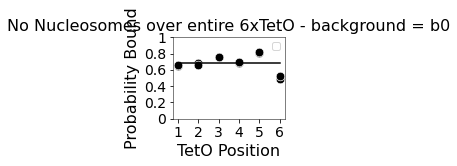

In [73]:
time = 24
n_tfbs = 6
background = 'b0'
single =all_promoter_annotations.loc[(all_promoter_annotations.drug.isin(['WT'])
                                &(all_promoter_annotations.background==background)
                                 &(all_promoter_annotations.n_tfbs==n_tfbs))]
replicates = single['replicates']
#single = single.loc[single['n_bound'].isin(nbound)]
tfbs_df = single.filter(like='tfbs_')
tfbs_list = ['tfbs_1','tfbs_2','tfbs_3','tfbs_4','tfbs_5','tfbs_6','tfbs_7','tfbs_8','tfbs_9']
drop_list = tfbs_list[n_tfbs:len(tfbs_list)]
tfbs_df = tfbs_df.drop(drop_list, axis=1) #need to systematically remove dropna

#BENS CODE FOR ASSIGNING TFS AS NUC BOUND

#for a particular amplicon, iterate through the TFs
tfbs_positions = positions_dict4['opJS4_6x_TetO_21bp_no_CG']
for idx_tf in range(len(tfbs_positions)):
    col = 'tfbs_{}'.format(idx_tf+1)
    pos = tfbs_positions[idx_tf]
    #get start and end of tf binding site
    start, end = pos[0], pos[1]
    #iterate through each nucleosome and ask if it overlaps this TF
    #if yes then make the value in tfbs_df for that tf 0.5 so it looks good in heatmap
    for idx_nuc in range(len(single.filter(like='nuc').columns.tolist())//3):
        #if the nucleosome exists AND 
        #the start of the nucleosome falls before the end of the tfbs AND #the end of the nucleosome is after the start of the tfbs
        #tfbs_df.loc[(single[('nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 2   

        tfbs_df.loc[(single['nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 0.5
        #tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
        
tfbs_df = tfbs_df*1


##label molecules as having or not having nucs
###################################################
#find molecules with no nucs and set them to 0
m= (tfbs_df.tfbs_1!=0.5)&(tfbs_df.tfbs_2!=0.5)&(tfbs_df.tfbs_3!=0.5)&(tfbs_df.tfbs_4!=0.5)&(tfbs_df.tfbs_5!=0.5)&(tfbs_df.tfbs_6!=0.5)
tfbs_df.loc[m, ['contains_nucs']] = 'No Nucleosomes'
#find molecules with nucs and set them to 1 
m2 = (tfbs_df.tfbs_1==0.5)|(tfbs_df.tfbs_2==0.5)|(tfbs_df.tfbs_3==0.5)|(tfbs_df.tfbs_4==0.5)|(tfbs_df.tfbs_5==0.5)|(tfbs_df.tfbs_6==0.5)
tfbs_df.loc[m2, ['contains_nucs']] = 'Nucleosomes'

###################################################

#set the nucs back to being black 
tfbs_cols = [col for col in tfbs_df.columns if 'tfbs' in col]
tfbs_df[tfbs_cols] = tfbs_df[tfbs_cols].replace(0.5, 0)
tfbs_df


tfbs_df = tfbs_df.join(replicates)
tfbs_df_no_nucs = tfbs_df[tfbs_df['contains_nucs'] == 'No Nucleosomes'].filter(like='tfbs_')
col_average = tfbs_df_no_nucs.mean(axis=0)

col_average

test = tfbs_df.groupby(['replicates','contains_nucs']).mean()
test.name = 'avg'
test = test.reset_index()
test = test[test['contains_nucs'] == 'No Nucleosomes']
test
#all_promoter_annotations['state1'] = all_promoter_annotations['cluster'].map(cluster_to_state1).fillna('nucleosome')
df2 = pd.melt(test, id_vars=["replicates", "contains_nucs"], 
                  var_name="TFBS", value_name="Value")
tfbs_dict = {'tfbs_1':1, 'tfbs_2':2,'tfbs_3':3,'tfbs_4':4,'tfbs_5':5, 'tfbs_6':6, 'tfbs_7':7}
df2['TFBS'] = df2['TFBS'].map(tfbs_dict)

fig, ax = plt.subplots(figsize=(2, 1.5))
sns.scatterplot(data = df2, x = 'TFBS', y = 'Value',ax = ax, s = 75, color='k')
ax.set_xlabel('TetO Position', fontsize = 16)
ax.set_ylabel('Probability Bound', fontsize = 16)
ax.set_ylim(0,1)
xticklist = list(range(1, n_tfbs+1))
ax.set_xticks(xticklist)
ax.set_xticklabels(labels = xticklist, fontsize = 14)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
ax.set_title('No Nucleosomes over entire 6xTetO - background = %s' % background, fontsize = 16)
# ax.legend(title='', labels = order, fontsize = 12, frameon = False)

xdata = df2['TFBS'].unique()
ydata = df2.groupby(['TFBS']).mean(['Value'])

x = np.linspace(1, 6, 1000)
plt.plot(x, np.full(len(x),np.mean(ydata)[0]), color='k')
plt.legend()
plt.savefig('fig2_plots/equal_binding_across_sites.pdf', dpi=600)

In [67]:
y_true = ydata['Value'].to_list()
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
cv(y_true)

15.410192267281102

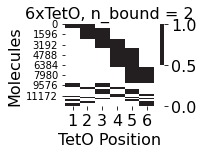

In [52]:
#MAKE PLOT OF ALL MOLECULES 2 BOUND, LOOKS PRETTY
time = 24
nbound = 2
#nbound = [3,4,5,6,7]
#single = ben_promoter_annotations2.loc[(ben_promoter_annotations2['n_tfbs']==7)
#                                      & (ben_promoter_annotations2.dox_time_min==time)]

#single = single.loc[single['n_bound'] == nbound] 
n_tfbs = 6
single =all_promoter_annotations.loc[(all_promoter_annotations.drug.isin(['WT'])
                                &(all_promoter_annotations.background=='b0')
                                 &(all_promoter_annotations.n_tfbs==n_tfbs))
                                    &(all_promoter_annotations.n_bound == nbound)]
#single = single.loc[single['n_bound'].isin(nbound)]

#NEW
tfbs_df = single.filter(like='tfbs_')
tfbs_list = ['tfbs_1','tfbs_2','tfbs_3','tfbs_4','tfbs_5','tfbs_6','tfbs_7','tfbs_8','tfbs_9']
drop_list = tfbs_list[n_tfbs:len(tfbs_list)]
tfbs_df = tfbs_df.drop(drop_list, axis=1) #need to systematically remove dropna

#tfbs_list = tfbs_df.columns.tolist() #might use this later


#tfbs_df2 = tfbs_df.drop_duplicates()
#tfbs_df2

#BENS CODE FOR ASSIGNING TFS AS NUC BOUND

# fill in nucs



#for a particular amplicon, iterate through the TFs
tfbs_positions = positions_dict4['opJS4_6x_TetO_21bp_no_CG']
for idx_tf in range(len(tfbs_positions)):
    col = 'tfbs_{}'.format(idx_tf+1)
    pos = tfbs_positions[idx_tf]
    #get start and end of tf binding site
    start, end = pos[0], pos[1]
    #iterate through each nucleosome and ask if it overlaps this TF
    #if yes then make the value in tfbs_df for that tf 0 so it looks good in heatmap
    for idx_nuc in range(len(single.filter(like='nuc').columns.tolist())//3):
        #if the nucleosome exists AND 
        #the start of the nucleosome falls before the end of the tfbs AND #the end of the nucleosome is after the start of the tfbs
        #tfbs_df.loc[(single[('nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 2   

        tfbs_df.loc[(single['nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 0.5
        #tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
        
tfbs_df = tfbs_df*1

###SELECT MOLS WITHOUT NUCS
##################################################
# tfbs_df = tfbs_df.loc[(tfbs_df.tfbs_1!=0.5)&
#                      (tfbs_df.tfbs_2!=0.5)&
#                      (tfbs_df.tfbs_3!=0.5)&
#                      (tfbs_df.tfbs_4!=0.5)&
#                      (tfbs_df.tfbs_5!=0.5)&
#                      (tfbs_df.tfbs_6!=0.5)]
###################################################


###SELECT MOLS WITH NUCS
##################################################
tfbs_df = tfbs_df.loc[(tfbs_df.tfbs_1==0.5)|
                     (tfbs_df.tfbs_2==0.5)|
                     (tfbs_df.tfbs_3==0.5)|
                     (tfbs_df.tfbs_4==0.5)|
                     (tfbs_df.tfbs_5==0.5)|
                     (tfbs_df.tfbs_6==0.5)]
###################################################

for idx_tf in range(len(tfbs_positions)):
    col = 'tfbs_{}'.format(idx_tf+1)
    pos = tfbs_positions[idx_tf]
    #get start and end of tf binding site
    start, end = pos[0], pos[1]
    #iterate through each nucleosome and ask if it overlaps this TF
    #if yes then make the value in tfbs_df for that tf 0 so it looks good in heatmap
    for idx_nuc in range(len(single.filter(like='nuc').columns.tolist())//3):
        #if the nucleosome exists AND 
        #the start of the nucleosome falls before the end of the tfbs AND #the end of the nucleosome is after the start of the tfbs
        #tfbs_df.loc[(single[('nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 2   

        tfbs_df.loc[(single['nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 0
        #tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
        
tfbs_df = tfbs_df*1


tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
# tfbs_df['norm_frac'] = tfbs_df['new_id'].map(tfbs_df['new_id'].value_counts(normalize = True))
# sorting on having co-bound sites in enhancer
# arr = tfbs_df[['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']].to_numpy()
# triples = [zip(a, a[1:]) for a in arr]
# tfbs_df['co_bound'] = [1 in [x for x,y in itertools.islice(triple, len(arr[0])-1) if x==y] for triple in triples]
di = {14:0, 9:1, 5:2, 2:3, 0:4, 13:5, 8:6, 4:7, 1:8,12:9,7:10,3:11,11:12,6:13,10:14}
tfbs_df['new_order'] = tfbs_df['new_id'].map(di)
tfbs_df = tfbs_df.sort_values(by = ['new_order'], ascending = True)


# #MAKE HEATMAP 
heat_df = tfbs_df.filter(like='tfbs_')
heat_df = heat_df*1
# heat_df = heat_df.loc[(heat_df.tfbs_1!=0.5)&
#                      (heat_df.tfbs_2!=0.5)&
#                      (heat_df.tfbs_3!=0.5)&
#                      (heat_df.tfbs_4!=0.5)&
#                      (heat_df.tfbs_5!=0.5)&
#                      (heat_df.tfbs_6!=0.5)]

heat_df = heat_df.reset_index()
heat_df = heat_df.drop(['index'], axis =1)
heat_df 
heat_df = heat_df.values.tolist()
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(2, 1.5))
g = sns.heatmap(heat_df, cmap = ['#FFFFFF','#231F20'])
fs = 16
g.set_title('6xTetO, n_bound = %i' % (nbound), fontsize = fs )
g.set_xlabel('TetO Position', fontsize = fs)
g.set_ylabel('Molecules', fontsize = fs)
g.set_xticklabels(labels = [1,2,3,4,5,6], fontsize =fs)
# g.set_yticks(ticks = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000], fontsize =fs)
# g.set_yticklabels(labels = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000], fontsize =fs)
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=fs)
order = tfbs_df['new_id'].unique()

plt.savefig('fig2_plots/2_bound_microstates_nucs.pdf', dpi=600)

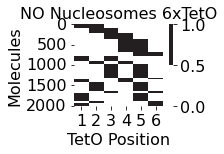

In [53]:
#MAKE NO NUCS 2 bound LOOKS PRETTY
time = 24
nbound = 2
#nbound = [3,4,5,6,7]
#single = ben_promoter_annotations2.loc[(ben_promoter_annotations2['n_tfbs']==7)
#                                      & (ben_promoter_annotations2.dox_time_min==time)]

#single = single.loc[single['n_bound'] == nbound] 
n_tfbs = 6
single =all_promoter_annotations.loc[(all_promoter_annotations.drug.isin(['WT'])
                                &(all_promoter_annotations.background=='b0')
                                 &(all_promoter_annotations.n_tfbs==n_tfbs))
                                    &(all_promoter_annotations.n_bound == nbound)]
#single = single.loc[single['n_bound'].isin(nbound)]

#NEW
tfbs_df = single.filter(like='tfbs_')
tfbs_list = ['tfbs_1','tfbs_2','tfbs_3','tfbs_4','tfbs_5','tfbs_6','tfbs_7','tfbs_8','tfbs_9']
drop_list = tfbs_list[n_tfbs:len(tfbs_list)]
tfbs_df = tfbs_df.drop(drop_list, axis=1) #need to systematically remove dropna

#tfbs_list = tfbs_df.columns.tolist() #might use this later


#tfbs_df2 = tfbs_df.drop_duplicates()
#tfbs_df2

#BENS CODE FOR ASSIGNING TFS AS NUC BOUND

# fill in nucs

#for a particular amplicon, iterate through the TFs
tfbs_positions = positions_dict4['opJS4_6x_TetO_21bp_no_CG']
for idx_tf in range(len(tfbs_positions)):
    col = 'tfbs_{}'.format(idx_tf+1)
    pos = tfbs_positions[idx_tf]
    #get start and end of tf binding site
    start, end = pos[0], pos[1]
    #iterate through each nucleosome and ask if it overlaps this TF
    #if yes then make the value in tfbs_df for that tf 0 so it looks good in heatmap
    for idx_nuc in range(len(single.filter(like='nuc').columns.tolist())//3):
        #if the nucleosome exists AND 
        #the start of the nucleosome falls before the end of the tfbs AND #the end of the nucleosome is after the start of the tfbs
        #tfbs_df.loc[(single[('nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 2   

        tfbs_df.loc[(single['nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 0.5
        #tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
        
tfbs_df = tfbs_df*1


###SELECT MOLS WITHOUT NUCS
##################################################
tfbs_df = tfbs_df.loc[(tfbs_df.tfbs_1!=0.5)&
                     (tfbs_df.tfbs_2!=0.5)&
                     (tfbs_df.tfbs_3!=0.5)&
                     (tfbs_df.tfbs_4!=0.5)&
                     (tfbs_df.tfbs_5!=0.5)&
                     (tfbs_df.tfbs_6!=0.5)]
###################################################

###SELECT MOLS WITH NUCS
##################################################
# tfbs_df = tfbs_df.loc[(tfbs_df.tfbs_1==0.5)|
#                      (tfbs_df.tfbs_2==0.5)|
#                      (tfbs_df.tfbs_3==0.5)|
#                      (tfbs_df.tfbs_4==0.5)|
#                      (tfbs_df.tfbs_5==0.5)|
#                      (tfbs_df.tfbs_6==0.5)]
###################################################


tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
# tfbs_df['norm_frac'] = tfbs_df['new_id'].map(tfbs_df['new_id'].value_counts(normalize = True))
# arr = tfbs_df[['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']].to_numpy()
# triples = [zip(a, a[1:], a[2:]) for a in arr]
# tfbs_df['nuc_compatible'] = [0 in [x for x,y,z in itertools.islice(triple, len(arr[0])-2) if x==y==z] for triple in triples]
# tfbs_df = tfbs_df.sort_values(by = ['new_id'], ascending = True)
# tfbs_df = tfbs_df.sort_values(by = ['norm_frac', 'new_id'], ascending = False)
di = {14:0, 9:1, 5:2, 2:3, 0:4, 13:5, 8:6, 4:7, 1:8,12:9,7:10,3:11,11:12,6:13,10:14}
tfbs_df['new_order'] = tfbs_df['new_id'].map(di)
tfbs_df = tfbs_df.sort_values(by = ['new_order'], ascending = True)



# #MAKE HEATMAP 
heat_df = tfbs_df.filter(like='tfbs_')
heat_df = heat_df*1
# heat_df = heat_df.loc[(heat_df.tfbs_1!=0.5)&
#                      (heat_df.tfbs_2!=0.5)&
#                      (heat_df.tfbs_3!=0.5)&
#                      (heat_df.tfbs_4!=0.5)&
#                      (heat_df.tfbs_5!=0.5)&
#                      (heat_df.tfbs_6!=0.5)]
#sns.heatmap(data = heat_df)
heat_df = heat_df.reset_index()
heat_df = heat_df.drop(['index'], axis =1)
heat_df 
#tfbs_list = heat_df.columns
heat_df = heat_df.values.tolist()
#plt = sns.heatmap(data = heat_df[tfbs_list])
#tfbs_list
heat_df
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(2, 1.5))

g = sns.heatmap(heat_df, cmap = ['#FFFFFF','#231F20'])
fs = 16
g.set_title('NO Nucleosomes 6xTetO',fontsize = fs )
g.set_xlabel('TetO Position', fontsize = fs)
g.set_ylabel('Molecules', fontsize = fs)
g.set_xticklabels(labels = [1,2,3,4,5,6], fontsize =fs)
g.set_yticks(ticks = [0, 500, 1000,1500, 2000], fontsize =fs)
g.set_yticklabels(labels = [0, 500, 1000,1500, 2000], fontsize =fs)
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=fs)

plt.savefig('fig2_plots/2_bound_microstates_no_nucs.pdf', dpi=600)
#plt.savefig(name) 


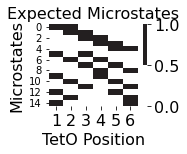

In [51]:
#MAKE PLOT OF EXPECTED MOLECULES 2 BOUND LOOKS PRETTY
time = 24
nbound = 2
#nbound = [3,4,5,6,7]
#single = ben_promoter_annotations2.loc[(ben_promoter_annotations2['n_tfbs']==7)
#                                      & (ben_promoter_annotations2.dox_time_min==time)]

#single = single.loc[single['n_bound'] == nbound] 
n_tfbs = 6
single =all_promoter_annotations.loc[(all_promoter_annotations.drug.isin(['WT'])
                                &(all_promoter_annotations.background=='b0')
                                 &(all_promoter_annotations.n_tfbs==n_tfbs))
                                    &(all_promoter_annotations.n_bound == nbound)]
#single = single.loc[single['n_bound'].isin(nbound)]

#NEW
tfbs_df = single.filter(like='tfbs_')
tfbs_list = ['tfbs_1','tfbs_2','tfbs_3','tfbs_4','tfbs_5','tfbs_6','tfbs_7','tfbs_8','tfbs_9']
drop_list = tfbs_list[n_tfbs:len(tfbs_list)]
tfbs_df = tfbs_df.drop(drop_list, axis=1) #need to systematically remove dropna

#tfbs_list = tfbs_df.columns.tolist() #might use this later


#tfbs_df2 = tfbs_df.drop_duplicates()
#tfbs_df2

#BENS CODE FOR ASSIGNING TFS AS NUC BOUND

# fill in nucs



#for a particular amplicon, iterate through the TFs
tfbs_positions = positions_dict4['opJS4_6x_TetO_21bp_no_CG']
for idx_tf in range(len(tfbs_positions)):
    col = 'tfbs_{}'.format(idx_tf+1)
    pos = tfbs_positions[idx_tf]
    #get start and end of tf binding site
    start, end = pos[0], pos[1]
    #iterate through each nucleosome and ask if it overlaps this TF
    #if yes then make the value in tfbs_df for that tf 0 so it looks good in heatmap
    for idx_nuc in range(len(single.filter(like='nuc').columns.tolist())//3):
        #if the nucleosome exists AND 
        #the start of the nucleosome falls before the end of the tfbs AND #the end of the nucleosome is after the start of the tfbs
        #tfbs_df.loc[(single[('nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 2   

        tfbs_df.loc[(single['nuc{}_present'.format(idx_nuc+1)]==True)&((single['nuc{}_start'.format(idx_nuc+1)]<=end)&(single['nuc{}_end'.format(idx_nuc+1)]>=start)),col] = 0
        #tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
        
tfbs_df = tfbs_df*1

###SELECT MOLS WITHOUT NUCS
##################################################
# tfbs_df = tfbs_df.loc[(tfbs_df.tfbs_1!=0.5)&
#                      (tfbs_df.tfbs_2!=0.5)&
#                      (tfbs_df.tfbs_3!=0.5)&
#                      (tfbs_df.tfbs_4!=0.5)&
#                      (tfbs_df.tfbs_5!=0.5)&
#                      (tfbs_df.tfbs_6!=0.5)]
###################################################


###SELECT MOLS WITH NUCS
##################################################
# tfbs_df = tfbs_df.loc[(tfbs_df.tfbs_1==0.5)|
#                      (tfbs_df.tfbs_2==0.5)|
#                      (tfbs_df.tfbs_3==0.5)|
#                      (tfbs_df.tfbs_4==0.5)|
#                      (tfbs_df.tfbs_5==0.5)|
#                      (tfbs_df.tfbs_6==0.5)]
###################################################


tfbs_df['new_id'] = tfbs_df.groupby(['tfbs_1', 'tfbs_2', 'tfbs_3', 'tfbs_4', 'tfbs_5', 'tfbs_6']).ngroup()
# tfbs_df['norm_frac'] = tfbs_df['new_id'].map(tfbs_df['new_id'].value_counts(normalize = True))
# tfbs_df = tfbs_df.sort_values(by = ['norm_frac', 'new_id'], ascending = False)
di = {14:0, 9:1, 5:2, 2:3, 0:4, 13:5, 8:6, 4:7, 1:8,12:9,7:10,3:11,11:12,6:13,10:14}
tfbs_df['new_order'] = tfbs_df['new_id'].map(di)
tfbs_df = tfbs_df.sort_values(by = ['new_order'], ascending = True)

tfbs_df = tfbs_df.drop_duplicates()
# #MAKE HEATMAP 
heat_df = tfbs_df.filter(like='tfbs_')
heat_df = heat_df*1
# heat_df = heat_df.loc[(heat_df.tfbs_1!=0.5)&
#                      (heat_df.tfbs_2!=0.5)&
#                      (heat_df.tfbs_3!=0.5)&
#                      (heat_df.tfbs_4!=0.5)&
#                      (heat_df.tfbs_5!=0.5)&
#                      (heat_df.tfbs_6!=0.5)]
#sns.heatmap(data = heat_df)
heat_df = heat_df.reset_index()
heat_df = heat_df.drop(['index'], axis =1)
heat_df 
#tfbs_list = heat_df.columns
heat_df = heat_df.values.tolist()
#plt = sns.heatmap(data = heat_df[tfbs_list])
#tfbs_list
from matplotlib import pyplot as plt
heat_df
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(2, 1.5))
g = sns.heatmap(heat_df, cmap = ['#FFFFFF','#231F20'])
fs = 16

g.set_xlabel('TetO Position', fontsize = fs)
g.set_title('Expected Microstates', fontsize = fs)
g.set_ylabel('Microstates', fontsize = fs)
g.set_xticklabels(labels = [1,2,3,4,5,6], fontsize =fs)
# g.set_yticks(ticks = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000], fontsize =fs)
# g.set_yticklabels(labels = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000], fontsize =fs)
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=fs)

# figpath = '/oak/stanford/groups/wjg/mhinks/projects/smf/230215_short_talk/'
# filename = 'expected_2bound_of_6x'
# name = figpath+filename +'.pdf'
# #plt.savefig(name) 
plt.savefig('fig2_plots/2_bound_microstates_expected.pdf', dpi=600)
